In [1]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt

In [20]:
table_data = pd.read_csv("/data1/yejb/prosit/figure3/supply_origin/combined-fine-tuned-IAA-noIAA-0.01.csv")


In [43]:

def read_allele_len(data, allele, length):
    alleles = data[data['Allele'] == allele]
    alleles = alleles[alleles['Sequence'].apply(lambda x: len(x) == length)]
    baseline = alleles[alleles['SM_v2'].apply(
        lambda x: bool(x))]['Sequence'].to_list()
    prosit = alleles[alleles['Prosit'].apply(
        lambda x: bool(x))]['Sequence'].to_list()
    finetuned = alleles[alleles['Fine-tuned Prosit'].apply(
        lambda x: bool(x))]['Sequence'].to_list()
    return baseline, prosit, finetuned

def LSG(p1, p2):
    p1 = set(p1)
    p2 = set(p2)
    return p1-p2, p1.intersection(p2), p2-p1

In [22]:
def all_unique_char(data):
    all_peptides = data["Sequence"]
    all_peptides = "".join(all_peptides)
    return set(all_peptides)

def extract_pos(peps, pos):
    return [ [p[i] for i in pos]for p in peps]

class Labeler:
    def __init__(self, unique_char):
        self._reverse = list(unique_char)
        self._dict = {
            c : i
            for i, c in enumerate(self._reverse)
        }
    def encode(self, peptide):
        return [self._dict[c] for c in peptide]

    def decode(self, pep_index):
        return "".join([self._reverse[i] for i in pep_index])
    
    def encode_batch(self, peptides):
        return [self.encode(p) for p in peptides]
    
    def decode_batch(self, pep_indexs):
        return [self.decode(p) for p in pep_indexs]
    
    def position_matrix(self, pep_indexs, length):
        mat = np.zeros((length, len(self._reverse)))    
        for p in pep_indexs:
            for i in range(length):
                mat[i, p[i]] += 1
        return mat
    
    def emission_mat(self, pep_indexs, length):
        mat = self.position_matrix(pep_indexs, length)
        return mat/(mat.sum(1).reshape(-1, 1) + 1e-9)
    
    def get_top_pos(self, pep_indexs, length, topk=5):
        mat = self.position_matrix(pep_indexs, length)
        pos_rank = np.max(mat, axis=1)
        return np.argsort(pos_rank)[::-1][:topk]

In [23]:
all_alleles = table_data['Allele'].unique()
all_length = [8, 9, 10, 11]

topk_pos = 5
labeller = Labeler(all_unique_char(table_data))


In [89]:
topk_pos = 5
def emission_prob(em_mat, pep_index):
    assert len(em_mat) == len(pep_index)
    prob = 0
    for i in range(len(em_mat)):
        prob += np.log10(1e-7 + em_mat[i, pep_index[i]])
    return prob

from tqdm import tqdm

prosit_dict = defaultdict(list)
finetuned_dict = defaultdict(list)
prosit_len = defaultdict(int)
finetuned_len = defaultdict(int)

all_length = [8, 9, 10, 11]
for allele in tqdm(all_alleles):
    ems_prosit = defaultdict(list)
    ems_finetuned = defaultdict(list)
    for length in all_length:
        baseline, prosit, finetuned = read_allele_len(
            table_data, allele, length)
        if len(baseline) == 0:
            continue
        # prosit
        baseline_i = labeller.encode_batch(set(baseline))
        needed_pos = labeller.get_top_pos(baseline_i, length, topk=topk_pos)

        inter = extract_pos(baseline_i, needed_pos)
        em_mat = labeller.emission_mat(inter, topk_pos)
        loss, shared, gain = LSG(baseline, prosit)
        for name, pep in zip(['Lost', 'Shared', "Gain"], [loss, shared, gain]):
            in_length = []
            pep_i = labeller.encode_batch(pep)
            if len(pep_i) == 0:
                continue
            pep_i = np.array(extract_pos(pep_i, needed_pos))
            for p in pep_i:
                s = emission_prob(em_mat, p)
                in_length.append(s)
            ems_prosit[name].append(np.mean(in_length))
        # finetuned
        baseline_i = labeller.encode_batch(set(prosit))
        needed_pos = labeller.get_top_pos(baseline_i, length, topk=topk_pos)
        inter = extract_pos(baseline_i, needed_pos)
        em_mat = labeller.emission_mat(inter, topk_pos)
        
        loss, shared, gain = LSG(prosit, finetuned)
        for name, pep in zip(['Lost', 'Shared', "Gain"], [loss, shared, gain]):
            in_length = []
            pep_i = labeller.encode_batch(pep)
            if len(pep_i) == 0:
                continue
            pep_i = np.array(extract_pos(pep_i, needed_pos))
            for p in pep_i:
                s = emission_prob(em_mat, p)
                in_length.append(s)
            ems_finetuned[name].append(np.mean(in_length))
    if len(ems_prosit) == 0 or len(ems_finetuned) == 0:
        print(f"Wrong shot at {allele}")
    for name in ['Lost', 'Shared', "Gain"]:
        prosit_dict[name].append(np.mean(ems_prosit[name]))
        prosit_len[name] += len(ems_prosit[name])
        finetuned_dict[name].append(np.mean(ems_finetuned[name]))
        finetuned_len[name] += len(ems_finetuned[name])


100%|██████████| 92/92 [00:18<00:00,  4.99it/s]


In [90]:
def plot_2_boxes(data1, df1, data2, df2, xlabels=None):
    plt.rcParams['text.usetex'] = False
    colors = ['pink', 'lightblue', 'lightgreen']
    medianprops = dict(linestyle='-.', linewidth=2.5, color='black')
    boxprops = dict(linestyle='-.', linewidth=2.5, color='black')
    def dict2data(okdict):
        data = []
        for name in ["Shared", "Gain", "Lost"]:
            data.append(okdict[name])
        return data
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), dpi=200)
    prosit_data = dict2data(data1)
    ft_add_data = dict2data(data2)
    labels = ["Shared", "Gain", "Lost"]
    bplot1 = ax1.boxplot(prosit_data,
                        notch=True,  # notch shape
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=labels,
                        medianprops=medianprops,
                        boxprops = boxprops,
                        showmeans=True, meanline=True)
    bplot2 = ax2.boxplot(ft_add_data,
                        notch=True,  # notch shape
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=labels,
                        medianprops=medianprops,
                        boxprops=boxprops,
                        showmeans=True, meanline=True)
    for bplot in (bplot1, bplot2):
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)
            
    for len_pd, ax in zip([df1, df2], [ax1, ax2]):
        ax.yaxis.grid(True)
        # ax.set_ylim([-0.1,1])
        # ax.text(
        #     0.85, 0.95, f"n=92", fontsize=10)
        # ax.text(
        #     1.85, 0.95, f"n=92", fontsize=10)
        # ax.text(
        #     2.85, 0.95, f"n=92", fontsize=10)
        # ax.text(0.85, -3.55, f"n={len_pd['Shared']}", fontsize=10)
        # ax.text(1.85, -3.55, f"n={len_pd['Gain']}", fontsize=10)
        # ax.text(
        #     2.85, -3.55, f"n={len_pd['Lost']}", fontsize=10)
    ax1.set_ylabel('Log10 Emission Probability', fontsize=15)
    if xlabels is None:
        ax1.set_xlabel("Prosit verus. SM HLA v2", fontsize=15)
        ax2.set_xlabel("FT Prosit verus. Prosit", fontsize=15)
    else:
        ax1.set_xlabel(xlabels[0], fontsize=15)
        ax2.set_xlabel(xlabels[1], fontsize=15)
    ax2.set_yticklabels([])
    plt.tight_layout()
    return fig, (ax1, ax2)

(-10.0, -3.0)

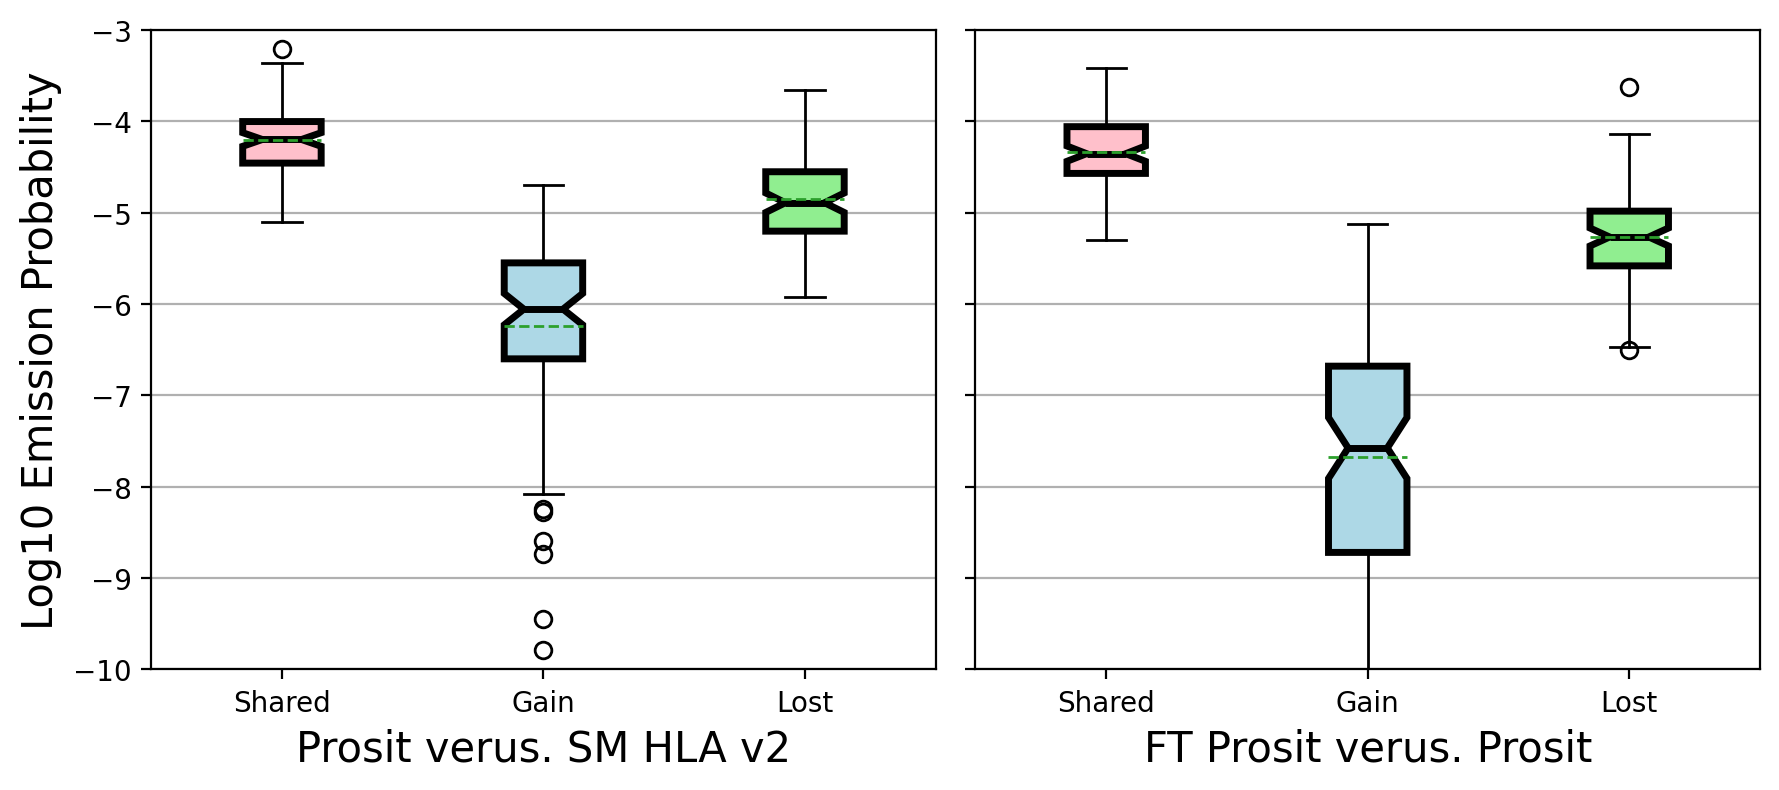

In [91]:
fig, (ax1, ax2) = plot_2_boxes(prosit_dict, prosit_len, finetuned_dict, finetuned_len)
ax1.set_ylim([-10, -3])
ax2.set_ylim([-10, -3])